In [1]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-12-08 22:24:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.207, 74.125.196.207, 74.125.134.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   181MB/s    in 0.9s    

2023-12-08 22:24:09 (181 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
!ls

10_food_classes_10_percent  10_food_classes_10_percent.zip  __MACOSX  sample_data


In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [4]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("10_food_classes_10_percent/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_data = train_generator.flow_from_directory(train_dir,batch_size=32,target_size=(224,224), class_mode='categorical',seed=42)

test_data = test_generator.flow_from_directory(test_dir,batch_size=32,target_size=(224,224), class_mode='categorical',seed=42)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [6]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [7]:
IMG_SIZE = 224
num_classes = 10
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

In [8]:
import tensorflow as tf
import keras
from keras import layers
from keras.applications import EfficientNetB0
from keras.applications import ResNet50
import tensorflow_hub as hub

In [9]:


def build_model(modeltype='Resnet50',num_classes=10):
  if 'Resnet50':
    feature_extractor_layer = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
  #else:
    #inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #feature_extractor_layer = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))

  #feature_extractor_layer.trainable = False
  for layer in feature_extractor_layer.layers:
    layer.trainable = False

  model = tf.keras.Sequential([
      feature_extractor_layer,
      #tf.keras.layers.Dense(10, 'softmax')
      #tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(num_classes, activation='softmax')  # Adjust num_classes based on your task
    ])


  return model

In [10]:
model_resnet_full = build_model('Resnet50')
model_resnet_full.compile(loss='categorical_crossentropy',  optimizer='adam',metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


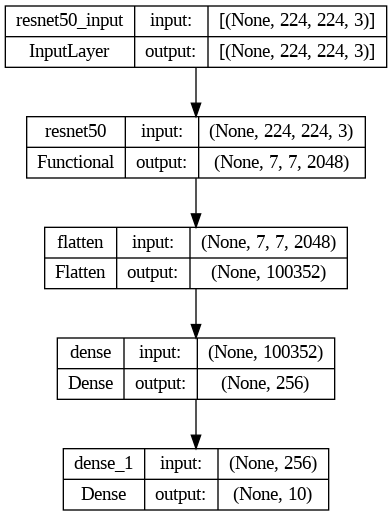

In [11]:
tf.keras.utils.plot_model(model_resnet_full, show_shapes=True, show_layer_names=True)

In [12]:
model_resnet_full.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 49280650 (187.99 MB)
Trainable params: 25692938 (98.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [13]:
print("weights:", len(model_resnet_full.weights))
print("trainable_weights:", len(model_resnet_full.trainable_weights))
print("non_trainable_weights:", len(model_resnet_full.non_trainable_weights))

weights: 322
trainable_weights: 4
non_trainable_weights: 318


In [14]:
history_resnet_full = model_resnet_full.fit(train_data,epochs=5, steps_per_epoch=len(train_data), validation_data=test_data,validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 27s 629ms/step - loss: 18.3757 - accuracy: 0.0880 - val_loss: 5.9262 - val_accuracy: 0.1212
Epoch 2/5
24/24 [==============================] - 13s 554ms/step - loss: 4.3525 - accuracy: 0.1280 - val_loss: 2.6549 - val_accuracy: 0.1152
Epoch 3/5
24/24 [==============================] - 11s 462ms/step - loss: 2.4277 - accuracy: 0.1893 - val_loss: 2.4840 - val_accuracy: 0.1404
Epoch 4/5
24/24 [==============================] - 11s 485ms/step - loss: 2.3240 - accuracy: 0.2293 - val_loss: 2.5333 - val_accuracy: 0.1304
Epoch 5/5
24/24 [==============================] - 11s 487ms/step - loss: 2.2371 - accuracy: 0.2547 - val_loss: 2.4013 - val_accuracy: 0.1576


In [15]:
# Resnet 50 V2 feature vector
resnet_url = "https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/1"
#resnet_url = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2"
#resnet_url = "https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Original: EfficientNetB0 feature vector (version 1)
#efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1"

In [16]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [17]:
input_shape=IMAGE_SHAPE+(3,)
input_shape

(224, 224, 3)

In [18]:
model_resnet = create_model(resnet_url)
model_resnet.compile(loss='categorical_crossentropy',  optimizer='adam',metrics=['accuracy'])

In [19]:
history_resnet = model_resnet.fit(train_data,epochs=5, steps_per_epoch=len(train_data), validation_data=test_data,validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 18s 541ms/step - loss: 2.0010 - accuracy: 0.3160 - val_loss: 1.2085 - val_accuracy: 0.6156
Epoch 2/5
24/24 [==============================] - 11s 487ms/step - loss: 0.9010 - accuracy: 0.7440 - val_loss: 0.8570 - val_accuracy: 0.7248
Epoch 3/5
24/24 [==============================] - 11s 472ms/step - loss: 0.6014 - accuracy: 0.8480 - val_loss: 0.7386 - val_accuracy: 0.7584
Epoch 4/5
24/24 [==============================] - 12s 506ms/step - loss: 0.4660 - accuracy: 0.8893 - val_loss: 0.7051 - val_accuracy: 0.7676
Epoch 5/5
24/24 [==============================] - 13s 561ms/step - loss: 0.3693 - accuracy: 0.9267 - val_loss: 0.6673 - val_accuracy: 0.7760


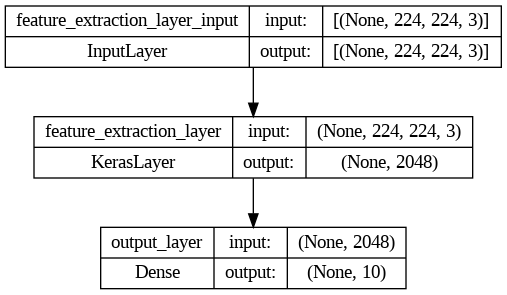

In [20]:
tf.keras.utils.plot_model(model_resnet, show_shapes=True, show_layer_names=True)

In [21]:
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [22]:
print("weights:", len(model_resnet.weights))
print("trainable_weights:", len(model_resnet.trainable_weights))
print("non_trainable_weights:", len(model_resnet.non_trainable_weights))

weights: 272
trainable_weights: 2
non_trainable_weights: 270


In [23]:
from keras import layers
dense = layers.Dense(64, activation="relu")
print("weights:", len(dense.weights))
print("trainable_weights:", len(dense.trainable_weights))
print("non_trainable_weights:", len(dense.non_trainable_weights))

weights: 0
trainable_weights: 0
non_trainable_weights: 0


In [24]:
import numpy as np
import keras
from keras import layers
#from keras import ops

In [25]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super().__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.linalg.matmul(inputs, self.w) + self.b


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model_custom = keras.Model(inputs, outputs)

In [26]:
model_custom.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 custom_dense (CustomDense)  (None, 10)                50        
                                                                 
Total params: 50 (200.00 Byte)
Trainable params: 50 (200.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


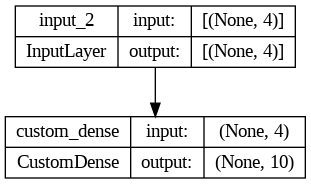

In [27]:
tf.keras.utils.plot_model(model_custom, show_shapes=True, show_layer_names=True)